In [162]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from scipy.optimize import minimize
from colorline import colorline

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from sys import path
path.insert(0, "lib")
from minima import *

%load_ext autoreload
%autoreload 2

In [127]:
class Langevin:
    """
    Langevin dynamics approximating SGD on a 2D model
    """
    def __init__(self, lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        mxx: expected value of X^2
        vxx: Var(X^2)
        vxy: Var(XY)
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.mxx = mxx
        self.std_xx = std_xx
        self.std_xy = std_xy
        self.w_init = w_init
        self.w = [self.w_init]
        self.state = np.random.RandomState(seed=seed)
        
    def update(self, w_old):
        xi_xx = self.state.normal(self.mxx, self.std_xx)
        xi_xy = self.state.normal(0.0, self.std_xy)
        return w_old - self.lr*(xi_xx * self.q(w_old) - xi_xy) * self.grad_q(w_old)
    
    def evolve(self, nstep):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc)
            self.w.append(wc)

In [199]:
def q(w):
    w1, w2 = w
    return w1*(w1*w1 + w2*w2)
    
def grad_q(w):
    w1, w2 = w
    return np.array([3*w1*w1 + w2*w2, 2*w1*w2])

lr = 0.1
mxx = 1.
std_xx = 1.
std_xy = 1.
w_init = np.array([0.1, 0.1])
seed = 42
L = Langevin(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
L.evolve(5000)

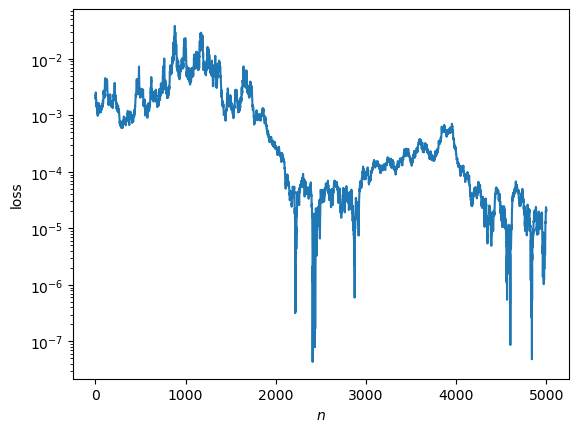

In [200]:
fig, ax = plt.subplots()
plt.plot(np.abs(L.q(np.array(L.w).T)))
ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel(r'$n$')
plt.ylabel('loss')
plt.savefig('2d_loss.png', dpi=150)
plt.show()

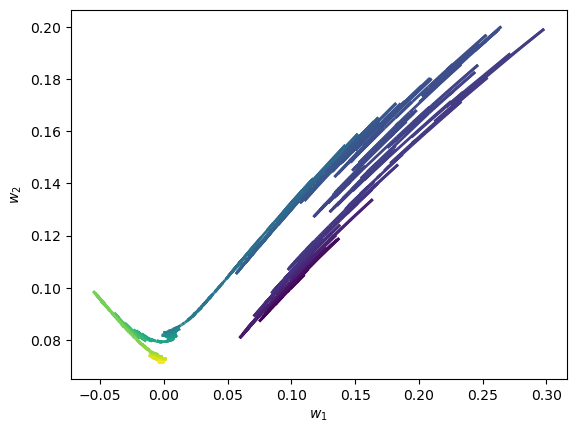

In [201]:
fig, ax = plt.subplots()
x, y = np.array(L.w).T
z = np.linspace(0, 1, len(x))
colorline(ax, x, y, z, cmap=plt.get_cmap('viridis'), linewidth=2)
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.savefig("2d_dynamics.png", dpi=150)

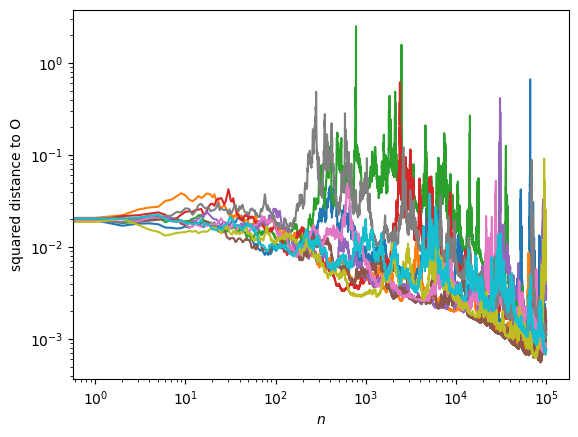

In [218]:
def q(w):
    w1, w2 = w
    return w1*(w1*w1 + w2*w2)
    
def grad_q(w):
    w1, w2 = w
    return np.array([3*w1*w1 + w2*w2, 2*w1*w2])

lr = 0.1
mxx = 1.
std_xx = 1.
std_xy = 1.
w_init = np.array([-0.1, -0.1])
fig, ax = plt.subplots()
for seed in range(10):
    L = Langevin(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
    L.evolve(100000)
#     plt.plot(*np.array(L.w).T)
    sq_dist = np.sum(np.array(L.w)**2., axis=1)
    plt.plot(sq_dist)
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('squared distance to O')
plt.xlabel('$n$')
plt.savefig("2d_sq_dist.png", dpi=150)
plt.show()